In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [3]:
dict_results = None
filename = 'test_sparse_matrix_gpu_sizes8192.json'
with open(filename, 'r') as fp:
    dict_results = json.load(fp)

In [4]:
for key, itms in dict_results.items():
    mean = np.mean(list(map(float, itms['dense_tensor']['8192'].values())))*1000
    print(key, mean, 'ms')

torch_mm 126.117528057346 ms
torch_matmul 127.41511021418 ms
torch_sparse_mm 127.84398779316832 ms


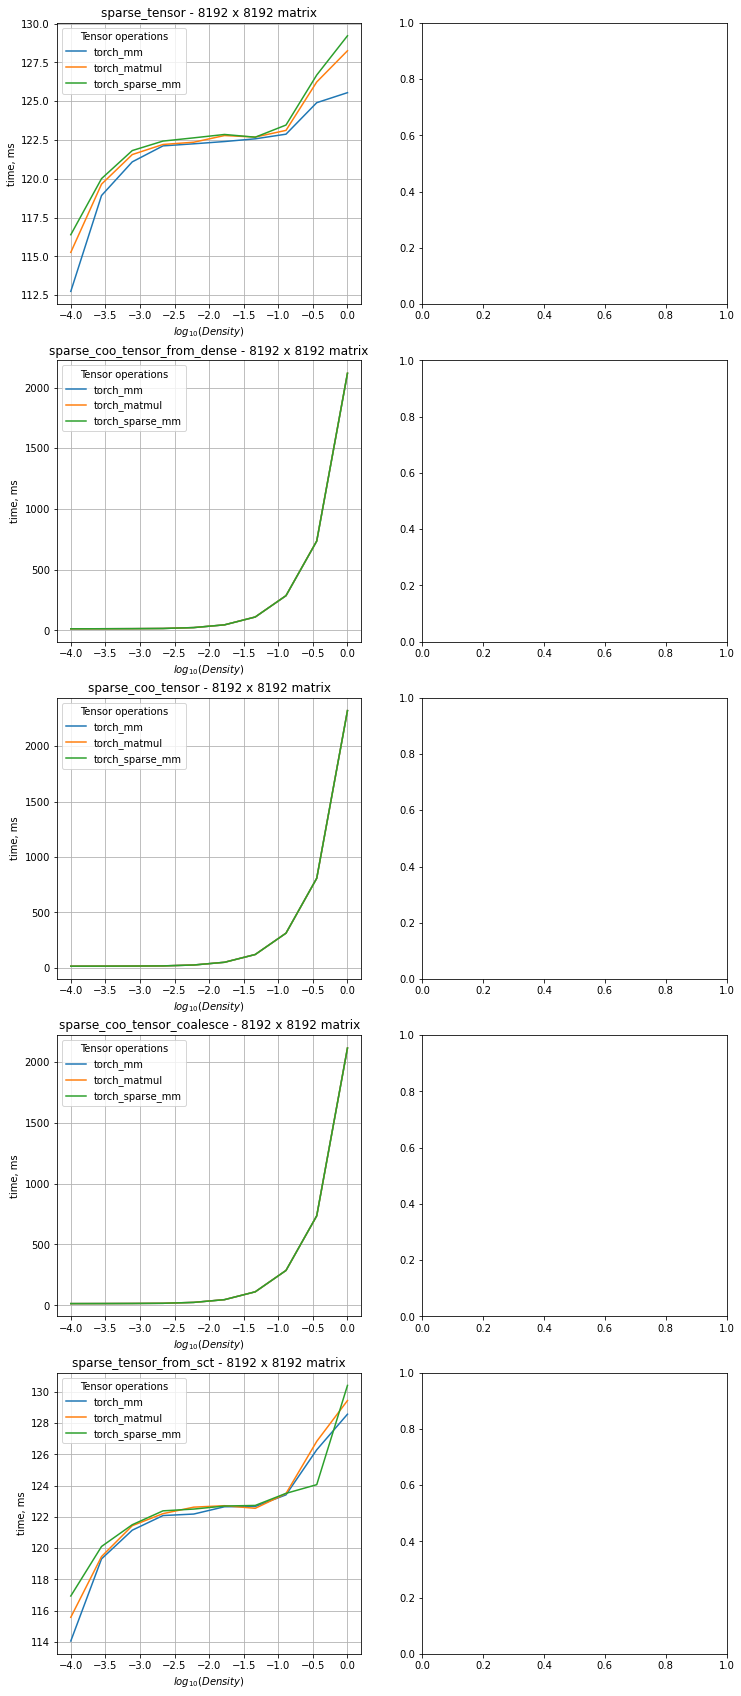

In [22]:
def _plot_comp_tensormethods_vs_sizes_accross_tensorops(dict_results):
    tensor_ops = list(dict_results.keys())
    tensor_methods = list(dict_results[tensor_ops[0]].keys())
    sizes = list(dict_results[tensor_ops[0]][tensor_methods[0]].keys())
    densities = list(dict_results[tensor_ops[0]][tensor_methods[0]][sizes[0]].keys())
    
    ref_name = 'dense_tensor'
    tensor_methods.remove(ref_name)

    nrows, ncols = len(tensor_methods), len(sizes) + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))

    for r, method in enumerate(tensor_methods):
        for c, size in enumerate(sorted(sizes)):
            for op in tensor_ops:
                xvals = np.log10(list(map(float, densities)))
                yvals = np.array(list(map(float, dict_results[op][method][size].values())))
                # yvals = (ref_vals / yvals - 1) * 100
                yvals = yvals * 1000
                axes[r][c].plot(xvals, yvals, label=str(op))

            axes[r][c].legend(title='Tensor operations')
            axes[r][c].set_title(f'{method} - {size} x {size} matrix')
            axes[r][c].set_xlabel(r'$log_{10}(Density)$')
            axes[r][c].set_ylabel(f'time, ms')
            axes[r][c].grid()
    return fig, axes
    
fig, axes = _plot_comp_tensormethods_vs_sizes_accross_tensorops(dict_results)
fig.savefig(f'{filename.split(".")[0]}_methods_vs_sizes_accross_ops.png')

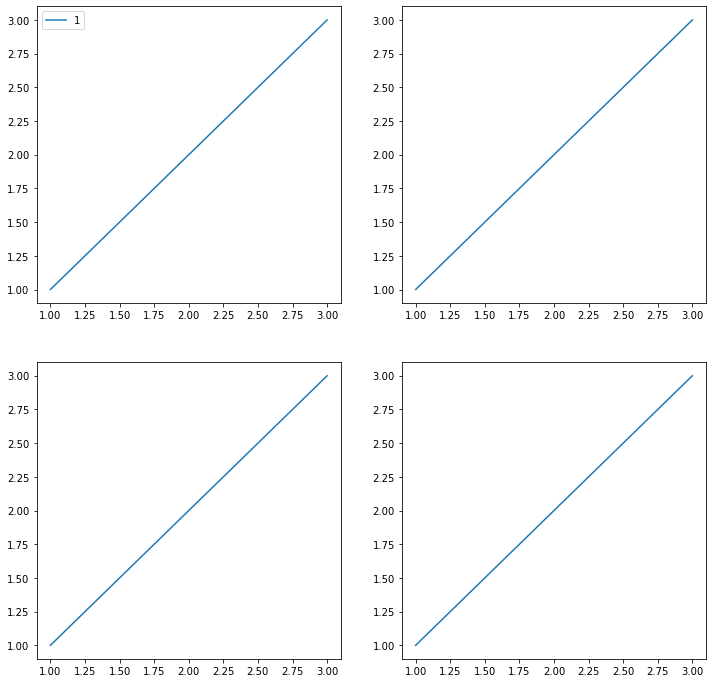

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
axes[0,0].plot([1,2,3],[1,2,3],label='1')
axes[0][0].legend()
axes[1][0].plot([1,2,3],[1,2,3])
axes[0][1].plot([1,2,3],[1,2,3])
axes[1][1].plot([1,2,3],[1,2,3])

In [4]:
def _plot_dvs_result(df, title = 'GPU', use_log10 = False):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 22}

    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    row_names = list(map(int, list(df.index)))
    row_values = [-val for val in row_names]

    # col_names = list(df.columns)
    # col_names.remove('Unnamed: 0')
    col_names = ['256', '512', '2048', '4096']

    for name in col_names:
        yvals = df.iloc[:][name].values
        if use_log10:
            yvals = np.log10(yvals)
        axes.plot(row_values, yvals, label=name)
    
    axes.legend(title='Size(n) of nxn matrix')
    axes.set_title(title)
    axes.set_xlabel(r'$log_{10}$(Density)')
    ylabel = r'$t_{matmul}\ /\ t_{sparse\_mm}$'
    if use_log10:
        ylabel = r'$log_{10}(t_{matmul}\ /\ t_{sparse\_mm})$'
    axes.set_ylabel(ylabel)
    return fig, axes


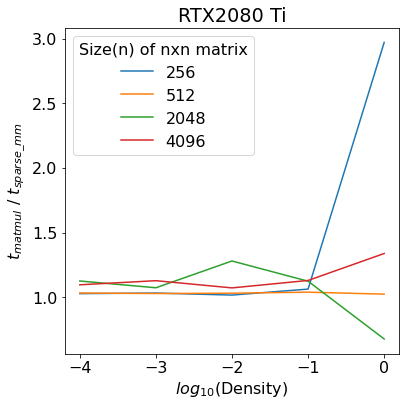

In [5]:
fig, axes = _plot_dvs_result(df_dvs_gpu, 'RTX2080 Ti')

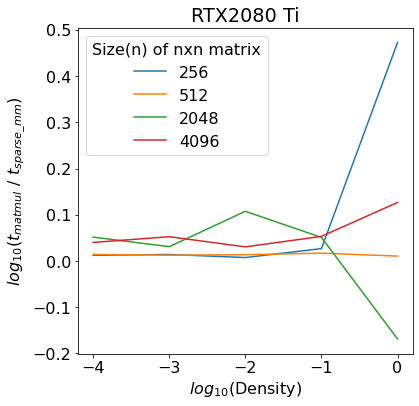

In [6]:
fig, axes = _plot_dvs_result(df_dvs_gpu, 'RTX2080 Ti', True)

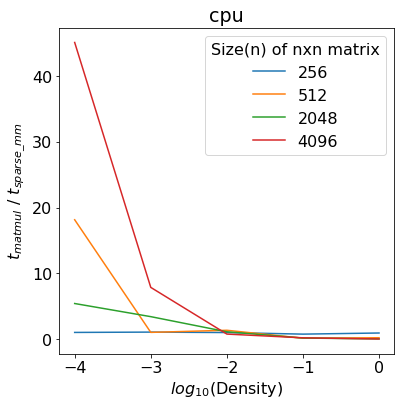

In [82]:
fig, axes = _plot_dvs_result(df_dvs_cpu, 'cpu')

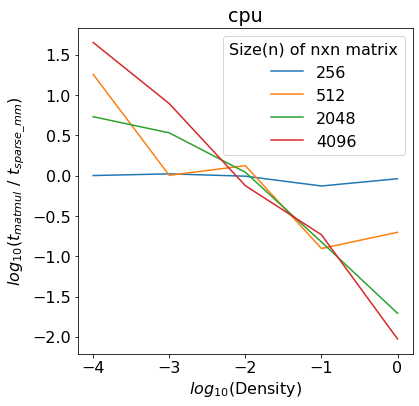

In [84]:
fig, axes = _plot_dvs_result(df_dvs_cpu, 'cpu', True)